# CCLE BRAF prediction validation in TCGA

In [1]:
from pnet import pnet_loader, Pnet
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os

%load_ext autoreload
%autoreload 2

## Load CCLE

In [2]:
gene_cn = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_gene_cn.csv').set_index('Unnamed: 0')
gene_cn.rename(columns=dict(zip(gene_cn.columns, [x.split(' ')[0] for x in gene_cn.columns])), inplace=True)

muts = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_mutations.csv')
muts.dropna(subset=['Variant_Classification'], inplace=True)

MUTATIONS_DICT = util.MUTATIONS_DICT

grouped_muts = muts[muts['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut = grouped_muts.unstack(level=-1).fillna(0).droplevel(0, axis=1)

v600e_mut_samples_ccle = muts[muts['Protein_Change']=='p.V600E']['Tumor_Sample_Barcode'].values

v600_target_ccle = pd.DataFrame(index=mut.index)
v600_target_ccle['v600_mut'] = [int(x in v600e_mut_samples_ccle) for x in mut.index]

rna = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_expression_full.csv').set_index('Unnamed: 0')
rna.rename(columns=dict(zip(rna.columns, [x.split(' ')[0] for x in rna.columns])), inplace=True)

genetic_data_ccle = {'rna': rna, 'mut': mut}

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (5,21,27,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's check which tumor type from CCLE has the most V600E mutations:

In [9]:
value_counts

,Category,Count
0,melanoma,53
1,colorectal,10
2,thyroid,7
3,glioma,6
4,breast,2
5,ovary,2
6,lung_NSC,2
7,AML,2
8,Ewings_sarcoma,1
9,soft_tissue,1


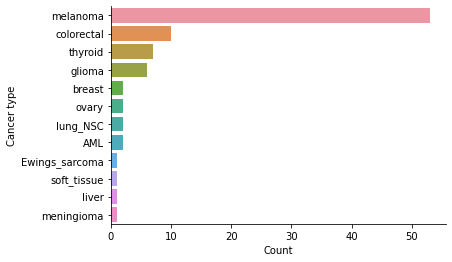

In [17]:
ccle_ann = pd.read_csv('/mnt/disks/pancan/CCLE/Cell_lines_annotations_20181226.txt', delimiter='\t')
annot_target = ccle_ann.join(v600_target_ccle, on='depMapID')

value_counts = annot_target[annot_target['v600_mut'] == 1]['type_refined'].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

sns.barplot(data=value_counts, y='Category', x='Count')
plt.ylabel('Cancer type')
plt.xlabel('Count')
sns.despine()

We see that Melanoma is the most appropriate cancer to validate our predictions on.

## Load TCGA

In [18]:
datapath='/mnt/disks/pancan/data/'
rna, cna, tumor_type, mut = util.load_tcga_dataset(datapath+'skcm_tcga_pan_can_atlas_2018', load_mut=True)

muts = pd.read_csv('/mnt/disks/pancan/data/skcm_tcga_pan_can_atlas_2018/data_mutations.txt', delimiter='\t')
muts.dropna(subset=['Variant_Classification'], inplace=True)

MUTATIONS_DICT = util.MUTATIONS_DICT

grouped_muts = muts[muts['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut = grouped_muts.unstack(level=-1).fillna(0).droplevel(0, axis=1)

v600e_mut_samples_tcga = muts[muts['HGVSp_Short']=='p.V600E']['Tumor_Sample_Barcode'].values

v600_target_tcga = pd.DataFrame(index=mut.index)
v600_target_tcga['v600_mut'] = [int(x in v600e_mut_samples_tcga) for x in mut.index]

genetic_data_tcga = {'rna': rna, 'mut': mut}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (4,38,39,43,84) have mixed types.Specify dtype option on import or set low_memory=False.
  
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (4,38,39,43,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))
canc_genes.remove('TP53')
canc_genes.remove('BRAF')
gene_overlap = set.intersection(set(genetic_data_ccle['rna'].columns), set(genetic_data_ccle['mut'].columns),
                                set(genetic_data_tcga['rna'].columns), set(genetic_data_tcga['mut'].columns),
                                canc_genes)

In [20]:
inds = pnet_loader.get_indicies(genetic_data = genetic_data_tcga,
                                target=v600_target_tcga)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = genetic_data_tcga,
                                          target=v600_target_tcga, indicies=inds, gene_set=gene_overlap)

Found 439 overlapping indicies
Found 673 overlapping genes
generated input DataFrame of size (439, 1346)


In [ ]:
class_weights = util.get_class_weights(torch.tensor(v600_target_ccle.values).view(-1))
for i in range(10):
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data_ccle, v600_target_ccle, seed=0,
                                                                                         dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights,
                                                                             save_path='../results/ccle_braf/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=gene_overlap)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_braf/run{}'.format(i))
    Pnet.evaluate_interpret_save(model, ext_val_dataset, '../results/tcga_braf/run{}'.format(i))

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 673 overlapping genes
generated input DataFrame of size (947, 1346)
Initializing Test Dataset
Found 673 overlapping genes
generated input DataFrame of size (236, 1346)
Found 673 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 673 overlapping genes
generated input DataFrame of size (947, 1346)
Initializing Test Dataset
Found 673 overlapping genes
generated input DataFrame of size (236, 1346)
Found 673 overlapping genes
We are sending to cuda
Hit early stopping criteria


In [ ]:
data_sets = ['tcga_braf', 'ccle_braf']
listl = []
for ds in data_sets:
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(ds, i))
        rf = ds.split('_')[-1]
        ds_ = ds.split('_')[0]
        if rf == 'rf':
            listl.append([auc.item(), ds_, 'RF'])
        else:
            listl.append([auc.item(), ds_, 'P-Net'])

auc_df = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df['Data Set'] = auc_df['Data Set'].apply(lambda x: x.upper() if x=='tcga' else x.upper())

In [ ]:
median_values = auc_df.groupby('Data Set')['AUC'].median().sort_values(ascending=False)
median_order = median_values.index.tolist()

custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'},
           order = median_order)
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/SKCM_BRAF_CCLE_vs_TCGA.pdf')
plt.show()